# CHiMaD Workshop: JCAP Example

This dataset consists of ~180K thin film materials ranging in composition and elemental structure.

In [25]:
import h5py    
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from dlhub_sdk.client import DLHubClient
from sklearn.ensemble import RandomForestRegressor
from mdf_forge import Forge
%matplotlib inline

### Retrieving Data with MDF Forge

In [62]:
import urllib
req = urllib.request.urlopen('https://data.materialsdatafacility.org/public/demo/jcap/computed/test_0/test_0.csv')
data = str(req.read()).split('\\n')[1:-1]
energy = [float(i.split(',')[0]) for i in data]
intensity = [float(i.split(',')[1]) for i in data]

In [72]:
req = urllib.request.urlopen('https://data.materialsdatafacility.org/public/demo/jcap/computed/test_0/test_0.png')
data = req.read()

In [29]:
mdf = Forge('mdf-test')

dataset_name = "sstein_stein_bandgap_2020"
r = mdf.match_resource_types("record").match_source_names(dataset_name)
r = r.search()

In [71]:
r = mdf.match_resource_types("record").\
    match_source_names(dataset_name).\
    match_elements(['Ag'], match_all=False)
subset, info = r.search(limit=100, info=True, reset_query=True)
print(info)

r = mdf.match_resource_types("record").\
    match_source_names(dataset_name).\
    match_elements(['Zn'], match_all=False)
subset, info = r.search(limit=100, info=True, reset_query=True)
print(info)

{'total_query_matches': 2435, 'advanced': True, 'limit': 100, 'query': '(mdf.resource_type:record) AND (mdf.source_name:sstein_stein_bandgap_2020) AND (material.elements:Ag)', 'index_uuid': '5acded0c-a534-45af-84be-dcf042e36412', 'retries': 0, 'errors': []}
{'total_query_matches': 1541, 'advanced': True, 'limit': 100, 'query': '(mdf.resource_type:record) AND (mdf.source_name:sstein_stein_bandgap_2020) AND (material.elements:Zn)', 'index_uuid': '5acded0c-a534-45af-84be-dcf042e36412', 'retries': 0, 'errors': []}


In [48]:
print(subset[3])

{'files': [{'data_type': 'Hierarchical Data Format (version 5) data', 'filename': 'dataset_comp_image_spectra.h5', 'globus': 'globus://82f1b5c6-6e9b-11e5-ba47-22000b92c6ec/public/demo/jcap/raw/dataset_comp_image_spectra.h5', 'length': 1717287078}], 'material': {'composition': 'Bi0.5V0.15000000596046448Mn0.3499999940395355', 'elemental_proportions': {'Mn': 0.3499999940395355}, 'elements': ['Bi', 'Mn', 'V']}, 'mdf': {'ingest_date': '2020-06-05T23:05:53.970939Z', 'resource_type': 'record', 'scroll_id': 65165, 'source_id': 'sstein_stein_bandgap_2020_v1.1', 'source_name': 'sstein_stein_bandgap_2020', 'version': 1}}


### Generating Useful Cuts on Thin Films Data

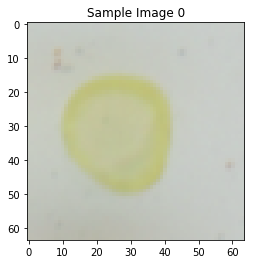

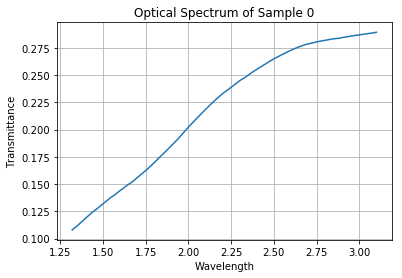

In [73]:
plt.figure()
plt.imshow(images[0])
plt.title('Sample Image 0')
plt.show()

plt.figure()
plt.plot(energy_eV,spectra[0])
plt.grid()
plt.title('Optical Spectrum of Sample 0')
plt.xlabel('Wavelength')
plt.ylabel('Transmittance')
plt.show()

### Analysis of Image Features Using A Random Forest Model

In [7]:
x_train = shuffled.values[:int(0.80*len(shuffled)),:-1]
y_train = shuffled.values[:int(0.80*len(shuffled)),-1]

x_test = shuffled.values[int(0.80*len(shuffled)):,:-1]
y_test = shuffled.values[int(0.80*len(shuffled)):,-1]


In [47]:
#MUST RESUBMIT DLHUB MODEL
DL = DLHubClient()
y_out_DL = DL.run(name = 'mschwarting_anl/Thin_Films_BG_RF', \
                  inputs=np.zeros([3,51]).tolist())[0]

In [11]:
rfr = RandomForestRegressor()
rfr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [12]:
y_out = rfr.predict(x_test)

In [14]:
plot_colors = np.array([i for i in zip(shuffled['R_channel avg'].tolist()[int(0.80*len(shuffled)):],\
                           shuffled['G_channel avg'].tolist()[int(0.80*len(shuffled)):],\
                           shuffled['B_channel avg'].tolist()[int(0.80*len(shuffled)):])])/255.


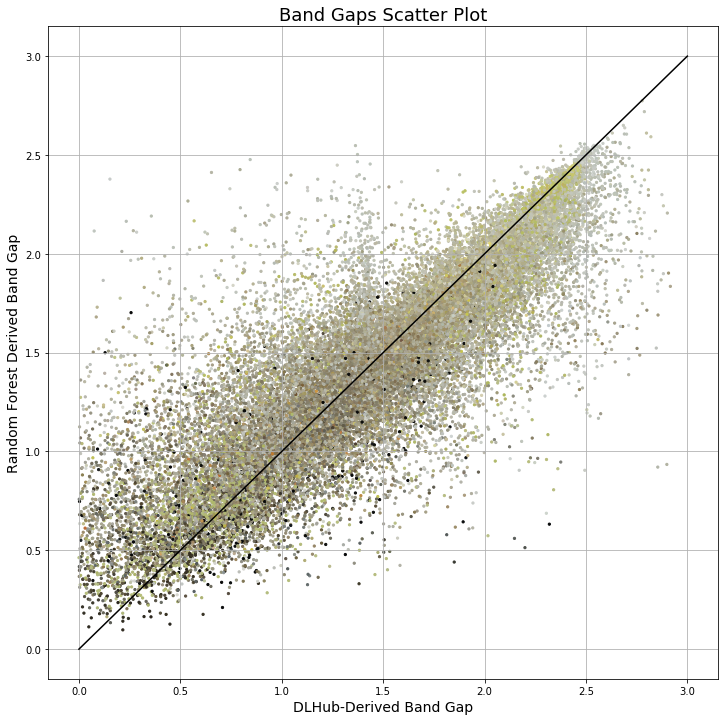

In [74]:
plt.figure(figsize=(12,12))
plt.scatter(y_test,y_out,s=5,alpha=1,color=plot_colors)
plt.xlabel('DLHub-Derived Band Gap',fontsize=14)
plt.ylabel('Random Forest Derived Band Gap',fontsize=14)
plt.title('Band Gaps Scatter Plot',fontsize=18)
plt.plot([0,3],[0,3],color='black')
plt.grid()
plt.show()